In [1]:
import datetime, time
from scipy.interpolate import griddata
import netCDF4
import numpy as np
from IPython.display import clear_output

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
% matplotlib inline

import utide
from pandas import DataFrame
from pandas import date_range
import datetime, time
import numpy as np
timeQ = time

class flow_zuno(): 
    def __init__(self): 
        
        a = 0
        b = -1
        c = 0
        d = -1
        e = 1

        nc = netCDF4.Dataset('E:/Use_case_Noorwegen/6_days/20190501000000.nc')
        x = nc.variables["x"][a:b, c:d][::e, ::e]
        y = nc.variables["y"][a:b, c:d][::e, ::e]  
        d_f = nc.variables["SEP"][:, a:b, c:d][:, ::e, ::e]
        t = nc.variables["time"][:]

        nc = netCDF4.Dataset('E:/Use_case_Noorwegen/6_days/20190503000000.nc')
        d2 = nc.variables["SEP"][:, a:b, c:d][:, ::e, ::e]
        t2 = nc.variables["time"][:]

        d_f = np.concatenate((d_f,d2))
        t = np.concatenate((t,t2))
        
        nc = netCDF4.Dataset('E:/Use_case_Noorwegen/6_days/20190505000000.nc')
        d2 = nc.variables["SEP"][:, a:b, c:d][:, ::e, ::e]
        t2 = nc.variables["time"][:]


        d = np.concatenate((d_f,d2))
        t = np.concatenate((t,t2))
        
        self.x = x
        self.y = y
        self.d = d
        self.t = t

def Tidal_analysis(time_orig, time, WD_raw, Rayleigh_min):
    coef_WD = utide.solve(time_orig, WD_raw,
                         lat=53,
                         nodal=False,
                         trend=False,
                         method='ols',
                         conf_int='linear',
                         Rayleigh_min=Rayleigh_min,)

    WD_predict = utide.reconstruct(time, coef_WD)
    clear_output()
    return WD_predict, coef_WD

In [2]:
f = flow_zuno()

In [3]:
a = 0
b = -1
time_orig = (f.t*60)/60/60/24
time = time_orig[a:(a+b)]
time_stamp = []
for T in time:
    time_stamp.append(datetime.datetime.fromtimestamp((T)*60*60*24))
time_stamp = np.array(time_stamp)
time_stamp_orig = []
for T in time_orig:
    time_stamp_orig.append(datetime.datetime.fromtimestamp(T*60*60*24))
time_stamp_orig = np.array(time_stamp_orig)
Rayleigh_min = 1


In [6]:
A = 5
N = 60

x = np.linspace(-15,15, N)
y = np.linspace(43,64,N)
x, y = np.meshgrid(x,y)
points = (f.x[::A, ::A].reshape(f.x[::A, ::A].size)[f.x[::A, ::A].reshape(f.x[::A, ::A].size).data < 100], 
          f.y[::A, ::A].reshape(f.x[::A, ::A].size)[f.x[::A, ::A].reshape(f.x[::A, ::A].size).data < 100]
         )

WD = []

for i in range(f.t.size):
    print(np.round(i/f.t.size*100), f.t.size)
    clear_output(wait=True)

    z = griddata(points, 
             f.d[i][::A, ::A].reshape(f.d[i][::A, ::A].size)[f.x[::A, ::A].reshape(f.x[::A, ::A].size).data < 100], 
             (x,y)
            )
    WD.append(z)
WD = np.array(WD)

99.0 144


In [7]:
#  ['M4', 'M3', 'M6', '3MK7', 'M8', 'K1', 'M2', '2MK5']

NAME = 'M2'

start = timeQ.time()

Phase = np.zeros(WD.shape[1:])
Amp = np.zeros(WD.shape[1:])


for i in range(N):
    for j in range(N):

        print(np.round(i/N/N*100), f.t.size)
        clear_output(wait=True)


        WD_raw = WD[:,i,j]

        if np.isnan(WD_raw).all():
            phase = np.nan
            amp = np.nan
        else:
            WD_predict, coef_WD = Tidal_analysis(time_orig, time, WD_raw, Rayleigh_min)
            phase = coef_WD['g'][np.argwhere(coef_WD['name'] == NAME)[0][0]]
            amp = coef_WD['A'][np.argwhere(coef_WD['name'] == NAME)[0][0]]

        Phase[i,j] = phase
        Amp[i,j] = amp

stop = timeQ.time()

print(np.round(stop  - start,2))

85.03


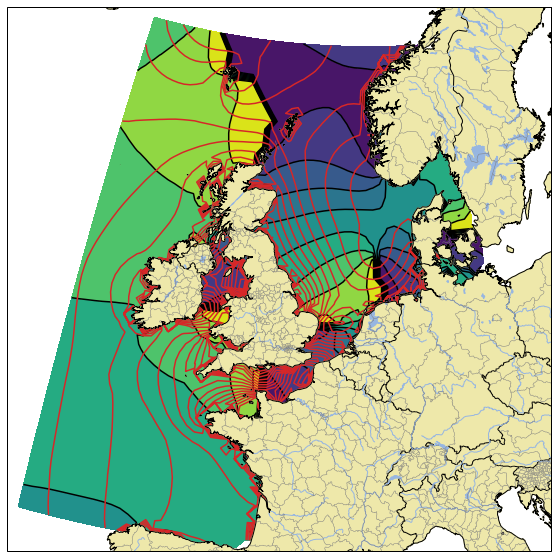

In [8]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.Orthographic(central_longitude=5, central_latitude=53))

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'), )
ax.add_feature(cfeature.RIVERS.with_scale('10m'), )
ax.coastlines(resolution='10m', color='k')
ax.add_feature(states_provinces, edgecolor='gray', linewidth = 0.5)

ax.set_extent([-15,15, 43,64])

c = np.linspace(0,360, 10)

plt.contourf(x,
             y,
             Phase,
             c,
             transform=ccrs.PlateCarree(),
             zorder = 0
            )

plt.contour(x,
             y,
             Phase,
             c,
             colors = 'black',
             linestyles='-',
             transform=ccrs.PlateCarree(),
            zorder = 1
            )

c = np.linspace(0,Amp[Amp == Amp].max()/1000, 20)

plt.contour(x,
             y,
             Amp,
             c,
             colors = 'tab:red',
             linestyles='-',
             transform=ccrs.PlateCarree(),
            zorder = 1
            )

plt.savefig('Cotidal-lines of {} constituent'.format(NAME))